# Numerical Playground

This notebook is a playground to facilitate the creation of the app: testing appropriate distributions, data generation methods, visualization routines etc.

As such, none of its content is needed to run / understand the app (which is self-contained, and better commented), but we still ship it for people that want to play with some Python functions directly without messing up with the streamlit setup.

## Data generation

Based on our b2b experience, we use a Gamma distribution as the main generating function for won deals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sps 

_Set some test parameters, print out descriptive stats and plot the empirical and theoretical dist_

In [2]:
def get_deal_distribution_by_product(
    products: list,
    shape_min: float,
    shape_max: float,
    scale_min: float,
    scale_max: float,
    n_deals: int = 1000,
    is_debug: bool = False
):
    prod2deals = {}
    shapes = np.random.uniform(shape_min, shape_max, len(products))
    scales = np.random.uniform(scale_min, scale_max, len(products))
    for idx, p in enumerate(products):
        s = np.random.gamma(shapes[idx], scales[idx], n_deals)
        prod2deals[p] = s
        if is_debug:
            print("\nProduct: {}".format(p))
            print("Mean {:.1f}, Median {:.1f}, Sum {:.1f}, Max {:.1f}".format(
                np.mean(s),
                np.median(s),
                np.sum(s),
                max(s)
            ))

    return prod2deals, shapes, scales

products = ["my_product"]
prod2deals, shapes, scales = get_deal_distribution_by_product(
    products, 
    shape_min=1.8, 
    shape_max=2.1,
    scale_min=40.0,
    scale_max=50.0, 
    n_deals=1000, 
    is_debug=True
)


Product: my_product
Mean 83.2, Median 67.7, Sum 83155.1, Max 395.1


In [3]:
def plot_gamma_with_theoretical(
    dist, # array with the distribution
    shape: float,
    scale: float
):
    # plot the empirical distribution
    count, bins, ignored = plt.hist(dist, 50, alpha=0.2, density=True)
    # plot the gamma function
    y = bins**(shape-1)*(np.exp(-bins/scale) / (sps.gamma(shape)*scale**shape))
    plt.plot(bins, y, linewidth=2, color='r')  
    plt.show()

    return

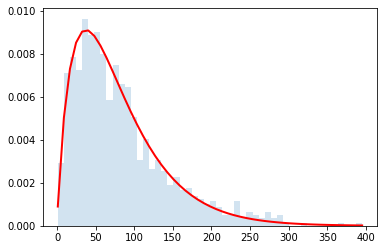

In [4]:
plot_gamma_with_theoretical(prod2deals[products[0]], shapes[0], scales[0])

_Now do the same, with N products_

In [65]:
products = ["product_{}".format(_) for _ in range(3)]
prod2deals, shapes, scales = get_deal_distribution_by_product(
    products, 
    shape_min=0.8, 
    shape_max=3.0,
    scale_min=40.0,
    scale_max=100.0, 
    n_deals=1000, 
    is_debug=True
)


Product: product_0
Mean 82.6, Median 62.0, Sum 82646.9, Max 478.5

Product: product_1
Mean 139.7, Median 124.2, Sum 139716.5, Max 542.7

Product: product_2
Mean 200.7, Median 177.1, Sum 200699.9, Max 803.6


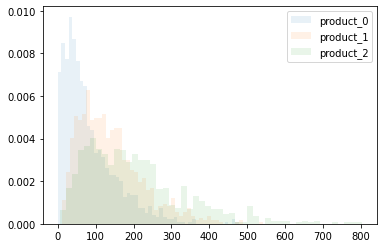

In [66]:
for p, dist in prod2deals.items():
    plt.hist(dist, 50, alpha=0.1, density=True, label=p) 

plt.legend()
plt.show()

_As an example, we dump the simulated deals in a file, which can be used for further analysis_

In [67]:
import json

with open('deals_data.json', 'w') as f:
    # note: need to dump ndarray to list
    json.dump({p: dist.tolist() for p, dist in prod2deals.items()}, f)

## Simulating a future quarter / time window

Based on the empirical distribution, how much money can we expect to make in the next quarter (or whatever time period)? 

This seemingly simple question has a seemingly simple answer: number of deals we close * mean deal value. As we see below, however, the more skewed the deal distribution, the harder it is to "narrow down" which, among the possible futures, is the one likely to materialize.

In particular, point-estimates may communicate a false sense of confidence in our predictions.

In [68]:
def simulate_future_revenues(
    dist, # historical distribution
    deals_we_close: int = 10, # deal we expect to close
    possible_futures: int = 100000, # future to simulate
    with_plot: bool=True,
    is_debug: bool=True
):
    # Store sum in a list. Repeat k times. Calculate mean and std of list.
    s = [sum(np.random.choice(dist, size=deals_we_close, replace=True)) for n in range(possible_futures)]
    if is_debug:
        print("Mean {:.1f}, Median {:.1f}, Sum {:.1f}, Std {:.1f}".format(
                    np.mean(s),
                    np.median(s),
                    np.sum(s),
                    np.std(s)
                ))
    
    if with_plot:
        plt.hist(s, 50, alpha=0.5, density=True) 
        plt.show()
    
    return

Mean 826.3, Median 806.6, Sum 82628733.0, Std 227.1


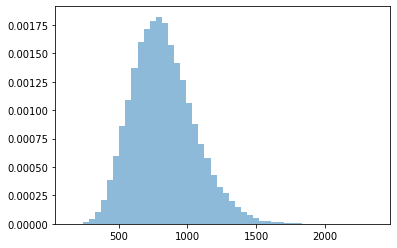

In [69]:
simulate_future_revenues(prod2deals["product_0"])


Product: product_0
Mean 50.4, Median 24.9, Sum 50383.2, Max 559.7
Mean 503.1, Median 472.2, Sum 50312867.0, Std 217.8


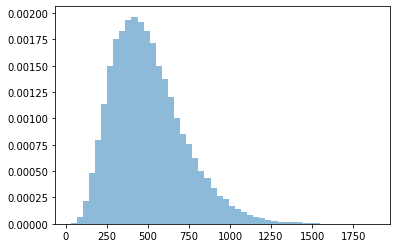

In [70]:
# play around with the distribution to see how future scenarios will change
prod2deals, shapes, scales = get_deal_distribution_by_product(
    ["product_0"], 
    shape_min=0.1, 
    shape_max=0.6,
    scale_min=90.0,
    scale_max=100.0, 
    n_deals=1000, 
    is_debug=True
)

simulate_future_revenues(prod2deals["product_0"])